Here we want to explore the 10X data to see if we can 'find the ambient barcodes'

In [5]:
import pyximport
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance
import umi_tools.umi_methods as umi_methods
import umi_tools.Utilities as U
import collections
import pandas as pd
import numpy as np
import pysam
import regex
import glob
import CGAT.Fastq as Fastq
import CGAT.IOTools as IOTools
from datetime import datetime
%load_ext rpy2.ipython
%matplotlib inline  

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
bam_infile = "../run/raw/hgmm_1k_possorted_genome_bam.bam"


In [7]:
def phredToInt(phreds):
    return(list(map(lambda x: ord(x)-33, phreds)))

qualities = collections.defaultdict(
    lambda: collections.defaultdict(collections.Counter))


read2genome = {}
genome2reads = collections.Counter()
cell_umi_counts = collections.defaultdict(set)
cell_counts = collections.Counter()
cell2species = collections.defaultdict(collections.Counter)
inbam = pysam.Samfile(bam_infile)
cell_counts_mapped = collections.defaultdict(collections.Counter)

n = 0
for read in inbam.fetch(until_eof=True):
    
    cell = read.get_tag('CR')
    umi = read.get_tag('UR')
    
    if read.is_secondary:
        continue
    
    if read.is_unmapped:
        cell_counts_mapped[cell]['unmapped'] += 1
    else:
        cell_counts_mapped[cell]['mapped'] += 1
        
        species = read.reference_name.split("_")[0]
        genome2reads[species] += 1
    
        if read.query_name in read2genome:
            raise ValueError("read: %s already seen: %s\n%s" %(
                read.query_name, read2genome[read.query_name], read))
        else:
            read2genome[read.query_name] = species
        
    n+=1
    
    if n % 1000000 == 0:
        print("processed %iM reads %s" % (
            (float(n)/1000000), datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    

    
    cell_umi_counts[cell].add(umi)
    cell_counts[cell] += 1
    cell2species[cell][species] += 1
    
    qualities[cell]['read'].update(read.query_qualities)
    qualities[cell]['cell'].update(phredToInt(read.get_tag('CY')))
    qualities[cell]['umi'].update(phredToInt(read.get_tag('UY')))

print(genome2reads)
print(qualities['CTCGTACGTGCCTGCA'])

processed 1M reads 2017-08-16 15:01:46
processed 2M reads 2017-08-16 15:02:24
processed 3M reads 2017-08-16 15:03:01
processed 4M reads 2017-08-16 15:03:37
processed 5M reads 2017-08-16 15:04:15
processed 6M reads 2017-08-16 15:04:54
processed 7M reads 2017-08-16 15:05:37
processed 8M reads 2017-08-16 15:06:20
processed 9M reads 2017-08-16 15:07:00
processed 10M reads 2017-08-16 15:07:40
processed 11M reads 2017-08-16 15:08:19
processed 12M reads 2017-08-16 15:08:58
processed 13M reads 2017-08-16 15:09:38
processed 14M reads 2017-08-16 15:10:20
processed 15M reads 2017-08-16 15:10:58
processed 16M reads 2017-08-16 15:11:38
processed 17M reads 2017-08-16 15:12:16
processed 18M reads 2017-08-16 15:12:54
processed 19M reads 2017-08-16 15:13:34
processed 20M reads 2017-08-16 15:14:15
processed 21M reads 2017-08-16 15:14:55
processed 22M reads 2017-08-16 15:15:33
processed 23M reads 2017-08-16 15:16:15
processed 24M reads 2017-08-16 15:16:57
processed 25M reads 2017-08-16 15:17:37
processed

In [8]:
def getCounterMeanPhred(counter):
    sum_prob = 0
    total_count = 0
    for number, count in counter.most_common():
        prob = 10**(number/(-10))
        sum_prob += (prob*count)
        total_count += count
    mean = sum_prob/total_count
    
    return mean 

print(cell)
print(qualities[cell]['read'])
print(getCounterMeanPhred(qualities[cell]['read']))
print(getCounterMeanPhred(collections.Counter((1,1,1,10))))
print(getCounterMeanPhred(collections.Counter((40,40,1,1))))

TTTGTCATCTTGGGTA
Counter({41: 170, 12: 131, 37: 95, 32: 87, 22: 59, 27: 45, 8: 1})
0.015260942228411312
0.6207461760432111
0.39721411736214074


In [10]:
def getCounterMean(counter):
    sum_of_numbers = sum([number*count for number, count in counter.most_common()])
    count = sum(count for n, count in counter.most_common())
    mean = sum_of_numbers / count
    return mean 

final_qualities = collections.defaultdict(lambda: collections.defaultdict(float))

for cell in qualities:
    try:
        final_qualities[cell]['read'] = getCounterMeanPhred(qualities[cell]['read'])
        final_qualities[cell]['cell'] = getCounterMeanPhred(qualities[cell]['cell'])
        final_qualities[cell]['umi'] = getCounterMeanPhred(qualities[cell]['umi'])
    except:
        print(cell)
        print(qualities[cell])

CTCGTACGTGCCTGCA
defaultdict(<class 'collections.Counter'>, {'read': Counter()})


In [11]:
print(qualities['NAGCCGAAGGAATGGA']['cell'])
print(getCounterMeanPhred(qualities['NAGCCGAAGGAATGGA']['cell']))

Counter({41: 25, 37: 11, 32: 8, 2: 3, 12: 1})
0.040941584078702443


In [12]:
print(qualities['CGGTTAAAGAGACTAT'])
print(getCounterMeanPhred(qualities['CGGTTAAAGAGACTAT']['read']))

defaultdict(<class 'collections.Counter'>, {'umi': Counter({41: 537, 37: 31, 32: 10, 22: 5, 27: 5, 12: 2}), 'read': Counter({41: 2837, 37: 1207, 32: 619, 12: 387, 27: 386, 22: 342, 8: 4}), 'cell': Counter({41: 595, 37: 198, 32: 138, 12: 7, 27: 6})})
0.004987338906591048


In [13]:
rows = []
n = 0
for cell in cell_umi_counts:
    
    row = (cell, cell_counts[cell], len(cell_umi_counts[cell]),
           1-(len(cell_umi_counts[cell])/cell_counts[cell]))
    
    rows.append(row)

#print(cell_umi_counts)

In [15]:
duplication_df = pd.DataFrame.from_records(
    rows, columns=["cell", "count", "unique_umi_count", "dup._rate"])
print(duplication_df.head())
print(duplication_df.shape)
duplication_df = duplication_df[duplication_df['count']>10]
print(duplication_df.shape)
print(duplication_df.sort_values("count", ascending=False).head())

               cell  count  unique_umi_count  dup._rate
0  CAACCAATCTGGGCCA      6                 4   0.333333
1  CCAGGACCTTGAGTGT      1                 1   0.000000
2  AAGCCGCCAGATAATG      9                 9   0.000000
3  CCTCAATATTCCTGCT      1                 1   0.000000
4  CCCACATCCACCTCCA      1                 1   0.000000
(860083, 4)
(133059, 4)
                    cell   count  unique_umi_count  dup._rate
526588  GTTAAGCTCAACTCTT  178148            119976   0.326537
710909  GTGCTTCTCGGGAGTA  164945            111737   0.322580
619598  ACGAGGAGTAGGGACT  156426            107095   0.315363
700214  GACTAACAGGCGCTCT  126206             87456   0.307038
382988  GGCAATTAGGAATCGC  124574             86563   0.305128


In [16]:
def getSpecificity(cell, cell2species, cell_counts):
    hg_counts = cell2species[cell]["hg19"]
    mm_counts = cell2species[cell]["mm10"]
    total = hg_counts + mm_counts
    assert total == cell_counts[cell]
    specificity = max(hg_counts, mm_counts) / (hg_counts + mm_counts)
    return specificity

def getAlignmentRate(cell, cell_counts_mapped, cell_counts):
    mapped = cell_counts_mapped[cell]["mapped"]
    unmapped = cell_counts_mapped[cell]["unmapped"]
    total = mapped + unmapped
    #if not total == cell_counts[cell]:
    #    print(cell, total, cell_counts[cell])
    #    raise ValueError()
    alignment = float(mapped)/total
    return alignment
                                   
print(cell2species['GACTGCGAGGGCATGT'])
print(getSpecificity('GACTGCGAGGGCATGT', cell2species, cell_counts))
print(getAlignmentRate('GACTGCGAGGGCATGT', cell_counts_mapped, cell_counts))

Counter({'hg19': 9, 'mm10': 8})
0.5294117647058824
0.7058823529411765


In [17]:
duplication_df['read_qual'] = [final_qualities[cell]['read'] for cell in duplication_df['cell']]
duplication_df['umi_qual'] = [final_qualities[cell]['umi'] for cell in duplication_df['cell']]
duplication_df['cell_qual'] = [final_qualities[cell]['cell'] for cell in duplication_df['cell']]
duplication_df['specificity'] = list(
    map(lambda x: getSpecificity(x, cell2species, cell_counts), duplication_df['cell']))
duplication_df['alignment_rate'] = [getAlignmentRate(x, cell_counts_mapped, cell_counts)
                                    for x in duplication_df['cell']]

In [18]:
def checkError(barcode, whitelist):
    near_matches = set()
    comp_regex = regex.compile("(%s){e<=1}" % barcode)
    comp_regex2 = regex.compile("(%s){e<=1}" % barcode[:-1])
    b_length = len(barcode)
    for whitelisted_barcode in whitelist:
        w_length = len(whitelisted_barcode)
        if barcode == whitelisted_barcode:
            continue
        if (max(b_length, w_length) > (min(b_length, w_length) + 1)):
            continue
        if comp_regex.match(whitelisted_barcode) or comp_regex2.match(whitelisted_barcode):
            near_matches.add(whitelisted_barcode)
            if len(near_matches) > 1:
                return near_matches

    return near_matches


In [21]:
def getWhitelistHard(duplication_df, n=100, return_set=True):
    whitelist = duplication_df.sort_values("count", ascending=False)[0:n]["cell"]
    if return_set:
        return set(whitelist)
    else:
        return whitelist.tolist()

whitelist = getWhitelistHard(duplication_df, n=1000)
duplication_df['whitelist'] = [True if x in whitelist else False for x in duplication_df['cell']]
print(len(whitelist))

1000


In [44]:
from itertools import chain

In [54]:
print([x for x in chain(range(200,900,100), range(900,1000,5))])

[200, 300, 400, 500, 600, 700, 800, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995]


In [75]:
def getErrorFreq(barcodes, whitelist):
    
    error = {}
    error["Error off whitelist"] = 0
    error["Error off (multiple) whitelist"] = 0 
    error["Error off (multiple) whitelist"] = 0
    error["No error"] = 0
    
    for barcode in barcodes:
        barcode_errors = checkError(barcode, whitelist)
    
        if len(barcode_errors) > 0:
            if len(barcode_errors) == 1:
                error["Error off whitelist"] += 1
            elif len(barcode_errors) == 2:
                error["Error off (multiple) whitelist"] += 1
            else:
                error["Error off (multiple) whitelist"] += 1
        else:
            error["No error"] += 1

    return error

sorted_duplication_df = duplication_df.sort_values(by="unique_umi_count", ascending=False)

rows = []
columns = ["threshold", "above_threshold",
           "Error_class", "count", "fraction"]
a
for whitelist_threshold in chain(range(200,900,100), range(900,1100,1)):
    whitelist_barcodes = sorted_duplication_df['cell'][0:whitelist_threshold].tolist()
    
    n_nearly_barcodes = min(100, int(whitelist_threshold * 0.25))
    nearly_barcodes = sorted_duplication_df['cell'][
        whitelist_threshold:whitelist_threshold + n_nearly_barcodes]
    
    lower_error = getErrorFreq(nearly_barcodes, whitelist_barcodes)
    
    for k,v in lower_error.items():
        rows.append([whitelist_threshold, 0, k, v, v/n_nearly_barcodes])

    upper_error = getErrorFreq(whitelist_barcodes[-(n_nearly_barcodes):], whitelist_barcodes)
    
    for k,v in upper_error.items():
        rows.append([whitelist_threshold, 1, k, v, v/n_nearly_barcodes])

    #print(whitelist_threshold, len(whitelist), len(whitelist_barcodes),
    #      len(top_barcodes), len(bottom_barcodes))
    #print(rows)
    
errors_df = pd.DataFrame.from_records(rows, columns=columns)
print(errors_df.head())


   threshold  above_threshold                     Error_class  count  fraction
0        200                0             Error off whitelist      0      0.00
1        200                0                        No error     50      1.00
2        200                0  Error off (multiple) whitelist      0      0.00
3        200                1             Error off whitelist      1      0.02
4        200                1                        No error     49      0.98


In [76]:
no_errors_df = errors_df[errors_df['Error_class']=="No error"]
print(no_errors_df[no_errors_df['threshold']==800].head())
print(no_errors_df[no_errors_df['fraction']<0.99].head(30))

    threshold  above_threshold Error_class  count  fraction
37        800                0    No error    100       1.0
40        800                1    No error    100       1.0
      threshold  above_threshold Error_class  count  fraction
4           200                1    No error     49      0.98
13          400                0    No error     98      0.98
22          500                1    No error     98      0.98
871        1038                0    No error     98      0.98
877        1039                0    No error     98      0.98
883        1040                0    No error     98      0.98
889        1041                0    No error     98      0.98
895        1042                0    No error     98      0.98
901        1043                0    No error     98      0.98
907        1044                0    No error     98      0.98
913        1045                0    No error     98      0.98
919        1046                0    No error     98      0.98
925        104

In [82]:
print(no_errors_df)

      threshold  above_threshold Error_class  count  fraction
1           200                0    No error     50      1.00
4           200                1    No error     49      0.98
7           300                0    No error     75      1.00
10          300                1    No error     75      1.00
13          400                0    No error     98      0.98
16          400                1    No error    100      1.00
19          500                0    No error    100      1.00
22          500                1    No error     98      0.98
25          600                0    No error    100      1.00
28          600                1    No error    100      1.00
31          700                0    No error    100      1.00
34          700                1    No error    100      1.00
37          800                0    No error    100      1.00
40          800                1    No error    100      1.00
43          900                0    No error    100      1.00
46      

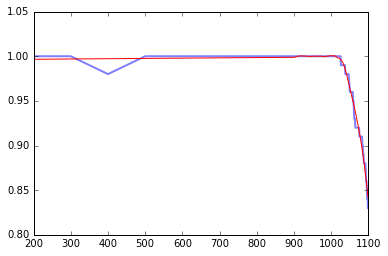

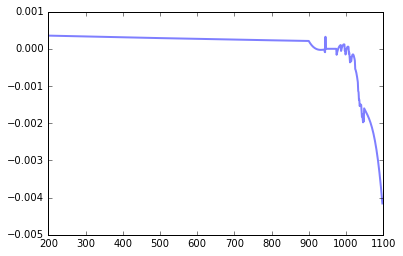

In [100]:
import numpy as np
from scipy.signal import savgol_filter as sg_filter
import matplotlib.pyplot as plt


# Generate some sample data similar to your post
X = no_errors_df[no_errors_df['above_threshold']==0]['threshold'].tolist()
Y = no_errors_df[no_errors_df['above_threshold']==0]['fraction'].tolist()

Y2 = sg_filter(Y, 101, 4)
Y3 = [Y2[x+1]-Y2[x] for x in range(0, len(Y2)-1)]

plt.plot(X,Y,linestyle='-', linewidth=2,alpha=.5)
plt.plot(X,Y2,color='r')

plt.show()

plt.plot(X[0:-1],Y3,linestyle='-', linewidth=2,alpha=.5)

plt.show()

  threshold above_threshold                    Error_class count fraction
0       200               0            Error off whitelist     0     0.00
1       200               0                       No error    50     1.00
2       200               0 Error off (multiple) whitelist     0     0.00
3       200               1            Error off whitelist     1     0.02
4       200               1                       No error    49     0.98
5       200               1 Error off (multiple) whitelist     0     0.00


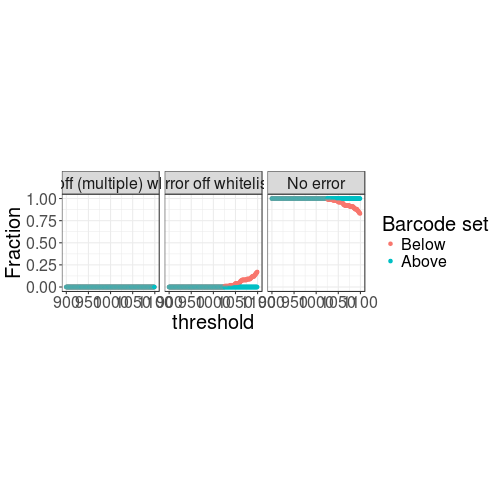

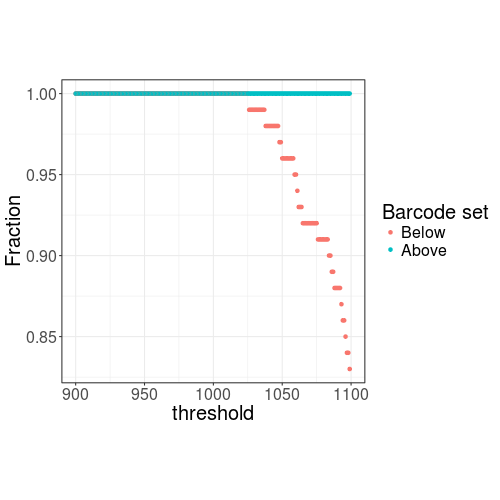

In [81]:
%%R -i errors_df -w 500 -h 500
library(ggplot2)
my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)
print(head(errors_df))

p <- ggplot(errors_df,
            aes(threshold, fraction, colour=as.factor(above_threshold))) +
geom_point() + my_theme + facet_wrap(~Error_class) + xlab("threshold") + ylab("Fraction") + 
scale_colour_discrete(name="Barcode set", labels=c("Below", "Above")) +
coord_cartesian(xlim=c(900,1100))

print(p)

p <- ggplot(errors_df[errors_df$Error_class=="No error",],
            aes(threshold, fraction, colour=as.factor(above_threshold))) +
geom_point() + my_theme + xlab("threshold") + ylab("Fraction") + 
scale_colour_discrete(name="Barcode set", labels=c("Below", "Above")) +
coord_cartesian(xlim=c(900,1100))

print(p)



In [65]:
error = []
error_barcode = []

n = 0
for barcode in duplication_df['cell']:
    n+=1
    if n % 10000 == 0:
        print("processed %i cell barcodes" % n)
    barcode_errors = checkError(barcode, whitelist)
    
    if len(barcode_errors) > 0:
        if len(barcode_errors) == 1:
            error_barcode.append(list(barcode_errors)[0])
            error.append("Error off whitelist")
        elif len(barcode_errors) == 2:
            error_barcode.append(list(barcode_errors)[0])
            error.append("Error off (multiple) whitelist")
        else:
            error_barcode.append("")
            error.append("Error off (multiple) whitelist")
    
    else:
        error.append("")
        error_barcode.append("")               
    
duplication_df['full_error'] = error
duplication_df['error_barcode'] = error_barcode

processed 10000 cell barcodes
processed 20000 cell barcodes
processed 30000 cell barcodes
processed 40000 cell barcodes
processed 50000 cell barcodes
processed 60000 cell barcodes
processed 70000 cell barcodes
processed 80000 cell barcodes
processed 90000 cell barcodes
processed 100000 cell barcodes
processed 110000 cell barcodes
processed 120000 cell barcodes
processed 130000 cell barcodes


In [68]:
print(sum(duplication_df[duplication_df['whitelist']==True]['count']))
print(sum(duplication_df[duplication_df['full_error']=='Error off whitelist']['count']))

53347784
1503049


In [69]:
duplication_df['N'] = ["N" in x for x in duplication_df['cell']]

In [70]:
%%R -i duplication_df

suppressMessages(library(ggplot2))
suppressMessages(library(Hmisc))

print(head(duplication_df))


               cell count unique_umi_count dup._rate   read_qual     umi_qual
4  CGGTTAAAGAGACTAT    59               40 0.3220339 0.004987339 0.0003777389
7  GGAACTTTCCTATGTT    71               54 0.2394366 0.006932875 0.0006778259
19 TGCTGCTGTCTCTTAT    72               50 0.3055556 0.006530845 0.0003791177
27 ACTATCTCATATGCTG 38561            27925 0.2758227 0.005021809 0.0004887776
31 TTAACTCTCGCAAACT    91               65 0.2857143 0.004589073 0.0003259011
32 CTCTGGTCACGGCTAC    48               39 0.1875000 0.006919386 0.0005199281
      cell_qual specificity alignment_rate full_error error_barcode whitelist
4  0.0006647061   0.5762712      0.9661017                              FALSE
7  0.0006671525   0.6197183      0.9295775                              FALSE
19 0.0003648975   0.6666667      0.9444444                              FALSE
27 0.0008308821   0.9898343      0.9408210                               TRUE
31 0.0004671664   0.5604396      0.9780220                      

In [71]:
%%R
my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)


[1] 4.157729


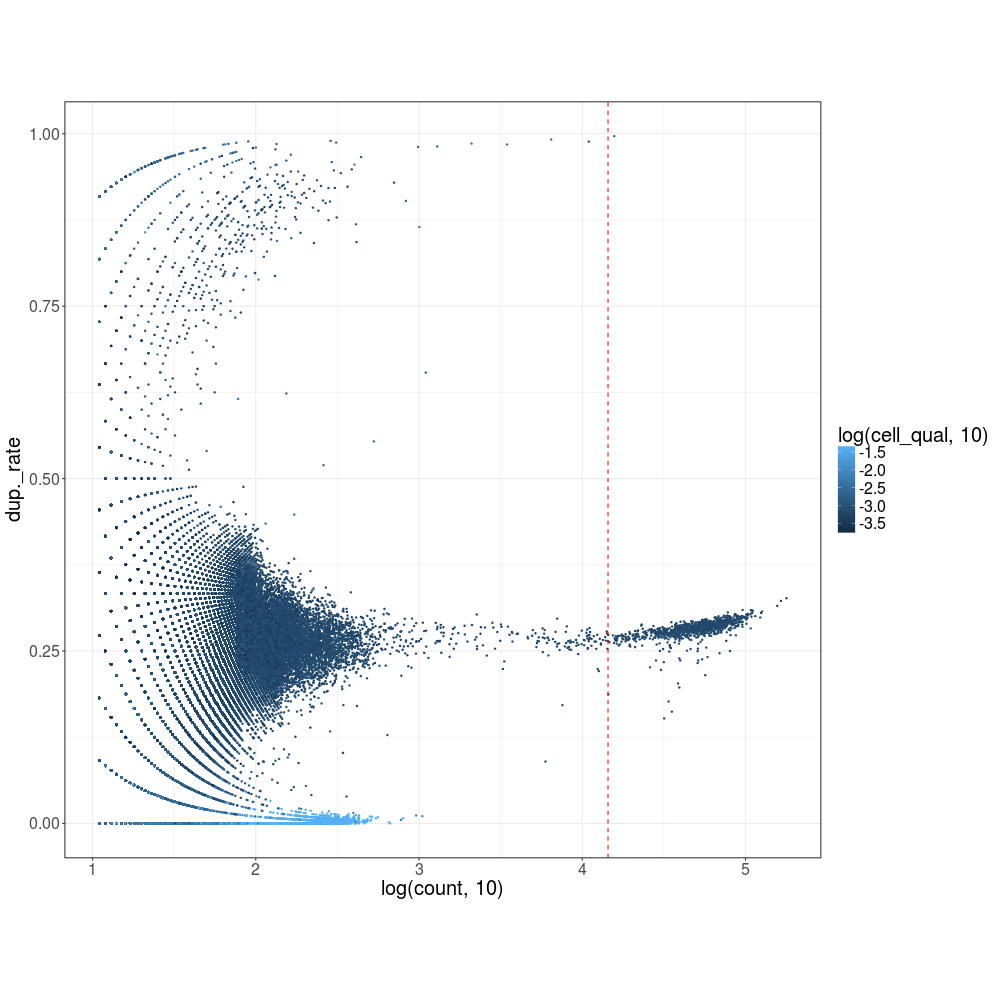

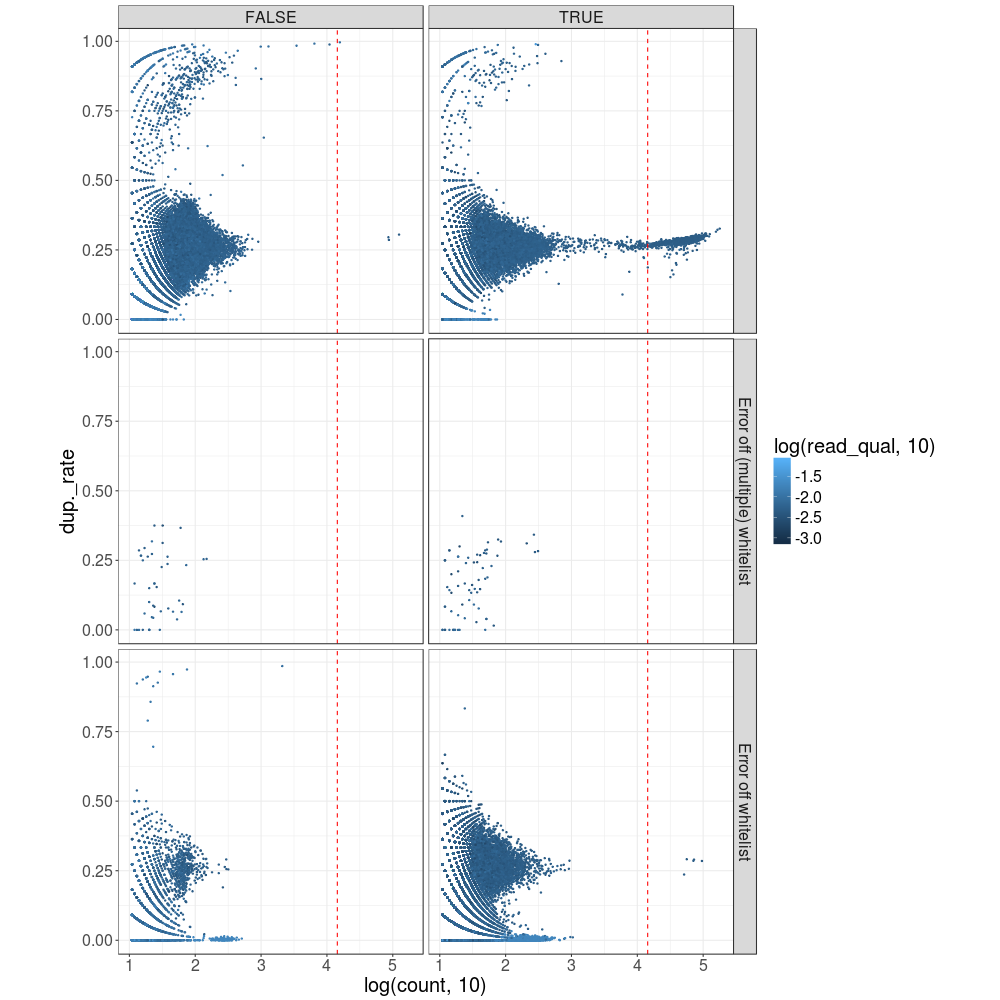

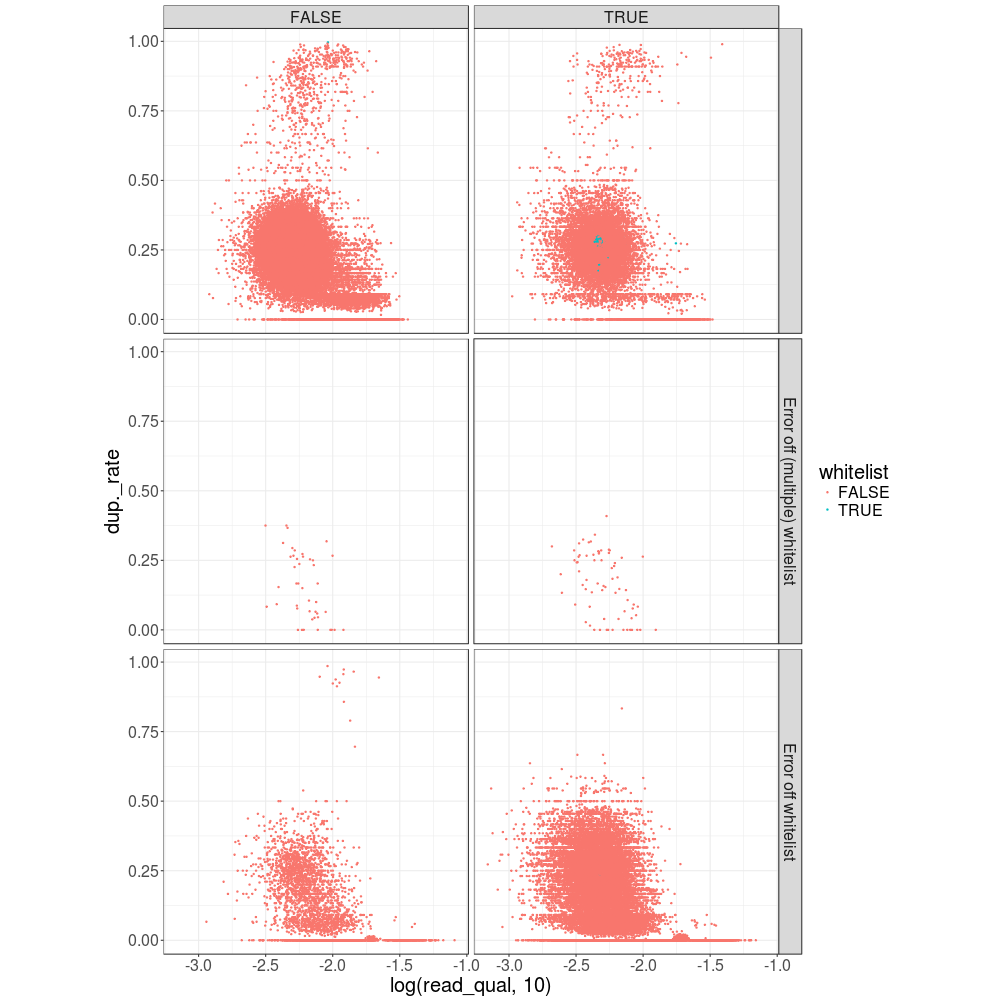

In [89]:
%%R -w 1000 -h 1000
duplication_df$specificity_binary <- duplication_df$specificity > 0.9

threshold = duplication_df[order(-duplication_df$count), "count"][1000]
threshold_umi = duplication_df[order(-duplication_df$unique_umi_count), "unique_umi_count"][1000]
print(log(threshold, 10))

p <- ggplot(duplication_df, aes(log(count,10), dup._rate, colour=log(cell_qual,10))) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2)

print(p) 

p <- ggplot(duplication_df, aes(log(count,10), dup._rate, colour=log(read_qual,10))) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
facet_grid(full_error~specificity_binary) #+
#scale_colour_continuous(low="red", high="steelblue", limits=c(20,35), na.value="steelblue")

print(p) 


p <- ggplot(duplication_df, aes(log(read_qual,10), dup._rate, colour=whitelist)) +
geom_point(size=0.5) + my_theme  +
facet_grid(full_error~specificity_binary)

print(p) 

p <- ggplot(duplication_df, aes(log(count,10))) + geom_density(adjust = 5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(2,5), ylim=c(0,0.05))

#print(p) 



In [73]:
%%R
print(dim(duplication_df))
duplication_error_barcodes = duplication_df[duplication_df['full_error']=="Error off whitelist",]
duplication_white_barcodes = duplication_df[duplication_df['whitelist']==TRUE,c("cell", "count")]
colnames(duplication_white_barcodes) <- c("cell", "true_count")
print(dim(duplication_error_barcodes))
print(dim(duplication_white_barcodes))

duplication_error_barcodes <- merge(
    duplication_error_barcodes, duplication_white_barcodes, by.x="error_barcode", by.y="cell", all.x=TRUE)

print(dim(duplication_error_barcodes))
print(head(duplication_error_barcodes))

print(sum(duplication_error_barcodes$count))
print(sum(duplication_white_barcodes$true_count))

[1] 133059     14
[1] 32557    14
[1] 1000    2
[1] 32557    15
     error_barcode             cell count unique_umi_count   dup._rate
1 AAACGGGAGAGTGAGA AAACGGGAGGGTGAGA    25               23 0.080000000
2 AAACGGGAGAGTGAGA AAACGGGAGAGTGGGA    16               16 0.000000000
3 AAACGGGAGAGTGAGA AAACGGGCGAGTGAGA    26               26 0.000000000
4 AAACGGGAGAGTGAGA AAACGGGAGCGTGAGA    46               46 0.000000000
5 AAACGGGAGAGTGAGA AAACGGGAGAGTGCGA    14               14 0.000000000
6 AAACGGGAGAGTGAGA NAACGGGAGAGTGAGA   230              229 0.004347826
    read_qual     umi_qual   cell_qual specificity alignment_rate
1 0.003548255 0.0017460759 0.003188500   1.0000000      1.0000000
2 0.004733910 0.0005701894 0.003049925   1.0000000      1.0000000
3 0.008057369 0.0043166079 0.010124244   0.9615385      0.9615385
4 0.010827323 0.0033437956 0.010166457   0.8913043      0.9130435
5 0.008701350 0.0049532530 0.007810101   1.0000000      1.0000000
6 0.018952702 0.0010355076 0.040569945   0.

In [74]:
%%R

duplication_error_barcodes$difference <- duplication_error_barcodes$count/duplication_error_barcodes$true_count

difference_per_true_barcode_df <- as.data.frame(as.list(aggregate(duplication_error_barcodes$count,
                    by=list("tb" = duplication_error_barcodes$error_barcode),
                    FUN = function(x) c(mean = mean(x), sd = sd(x), n = length(x)))))

difference_per_true_barcode_df <- merge(difference_per_true_barcode_df,
                                        duplication_white_barcodes,
                                        by.x="tb", by.y="cell",all.x=TRUE) 
                        
colnames(difference_per_true_barcode_df) <- c("TB", "mean", "sd", "n", "tb_count")
                        
print(head(difference_per_true_barcode_df))
                        
final_duplication_error_barcodes <- merge(duplication_error_barcodes, difference_per_true_barcode_df,
                                    by.x="error_barcode", by.y="TB", all.x=TRUE)
print(head(final_duplication_error_barcodes))

                TB     mean       sd  n tb_count
1 AAACGGGAGAGTGAGA 32.64000 44.04437 25    54812
2 AAACGGGCACATTTCT 36.69048 54.25841 42    89399
3 AAAGATGAGACGACGT 44.32143 59.77058 28    71232
4 AAAGATGAGCATCATC 41.59459 67.28854 37    84400
5 AAAGATGCAGCGTAAG 40.31818 53.91739 22    57019
6 AAAGCAAAGCTAGCCC 40.21622 51.02240 37    52605
     error_barcode             cell count unique_umi_count   dup._rate
1 AAACGGGAGAGTGAGA AAACGGGAGGGTGAGA    25               23 0.080000000
2 AAACGGGAGAGTGAGA AAACGGGAGAGTGGGA    16               16 0.000000000
3 AAACGGGAGAGTGAGA AAACGGGCGAGTGAGA    26               26 0.000000000
4 AAACGGGAGAGTGAGA AAACGGGAGCGTGAGA    46               46 0.000000000
5 AAACGGGAGAGTGAGA AAACGGGAGAGTGCGA    14               14 0.000000000
6 AAACGGGAGAGTGAGA NAACGGGAGAGTGAGA   230              229 0.004347826
    read_qual     umi_qual   cell_qual specificity alignment_rate
1 0.003548255 0.0017460759 0.003188500   1.0000000      1.0000000
2 0.004733910 0.0005701894 0

                TB     mean       sd  n tb_count
1 AAACGGGAGAGTGAGA 32.64000 44.04437 25    54812
2 AAACGGGCACATTTCT 36.69048 54.25841 42    89399
3 AAAGATGAGACGACGT 44.32143 59.77058 28    71232
4 AAAGATGAGCATCATC 41.59459 67.28854 37    84400
5 AAAGATGCAGCGTAAG 40.31818 53.91739 22    57019
6 AAAGCAAAGCTAGCCC 40.21622 51.02240 37    52605


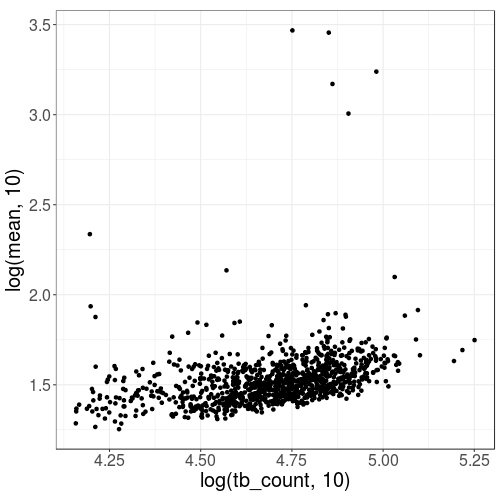

In [81]:
%%R -w 500 -h 500 

print(head(difference_per_true_barcode_df))

p <- ggplot(difference_per_true_barcode_df, aes(log(tb_count,10))) +
my_theme +
geom_point(aes(y=log(mean,10))) #+
#geom_errorbar(aes(ymin=log(mean,10)-log(sd,10), ymax=log(mean,10)+log(sd,10), width=0.01))
#geom_errorbar(aes(ymin=log(mean-(3*sd),10), ymax=log(mean-(3*sd),10)), width=0.2)

print(p)

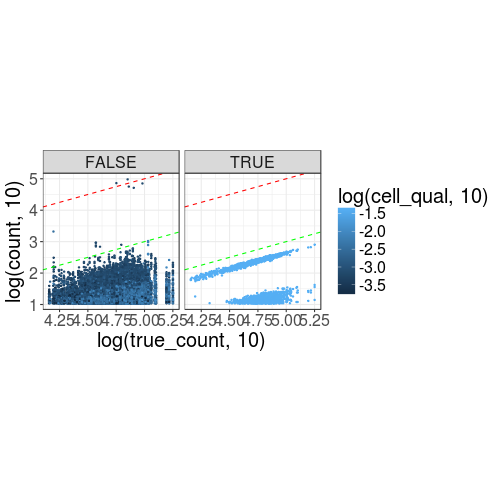

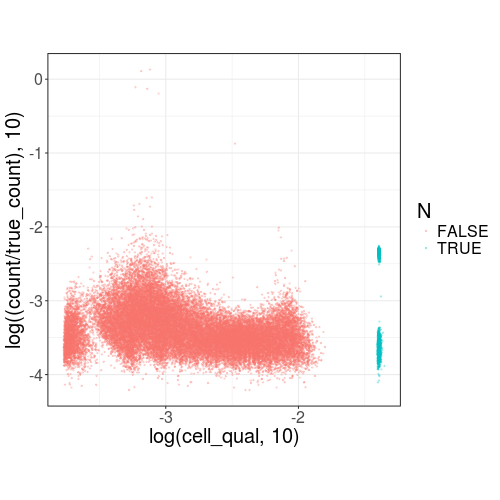

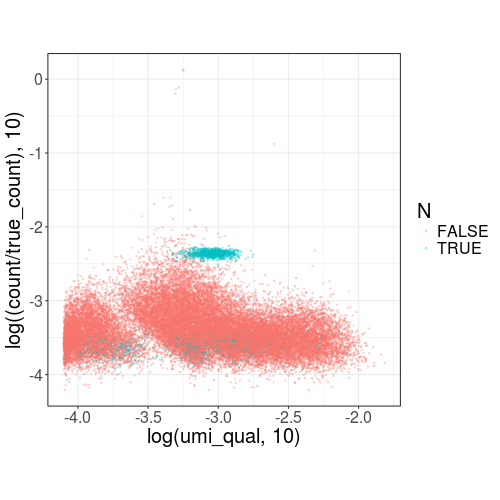

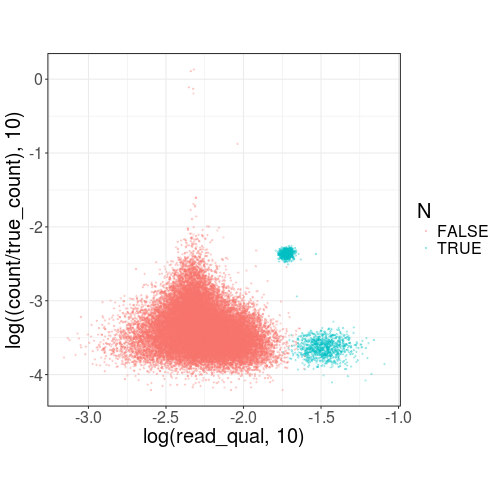

In [91]:
%%R -w 500 -h 500



p <- ggplot(duplication_error_barcodes, aes(log(true_count,10), log(count,10), colour=log(cell_qual,10))) +
geom_point(size=0.5) + my_theme + geom_abline(slope=1, colour="red", linetype=2) +
facet_wrap(~N) +
geom_abline(slope=1, colour="green", linetype=2, intercept=-2)

print(p)

p <- ggplot(duplication_error_barcodes, aes(log(cell_qual,10), log((count/true_count),10), colour=N)) +
geom_point(size=0.5, alpha=0.25) + my_theme

print(p)

p <- ggplot(duplication_error_barcodes, aes(log(umi_qual,10), log((count/true_count),10), colour=N)) +
geom_point(size=0.5, alpha=0.25) + my_theme

print(p)

p <- ggplot(duplication_error_barcodes, aes(log(read_qual,10), log((count/true_count),10), colour=N)) +
geom_point(size=0.5, alpha=0.25) + my_theme

print(p)

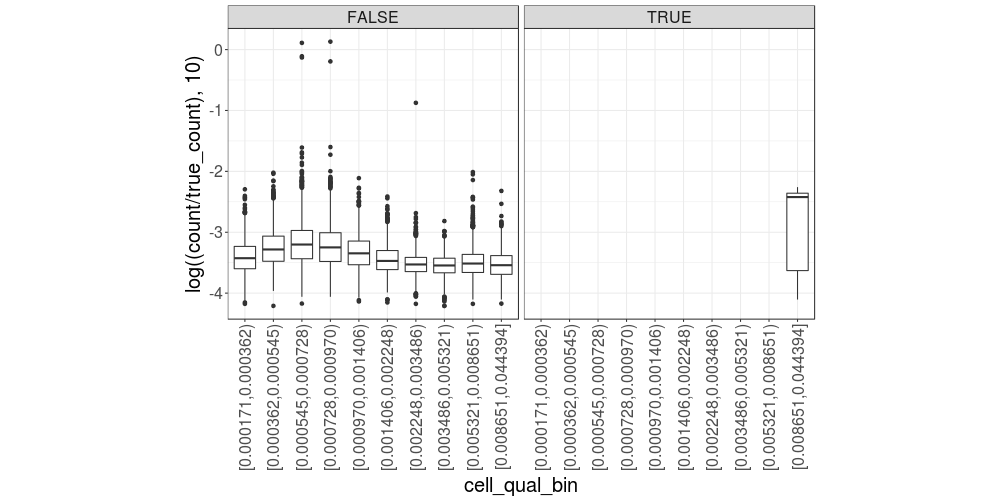

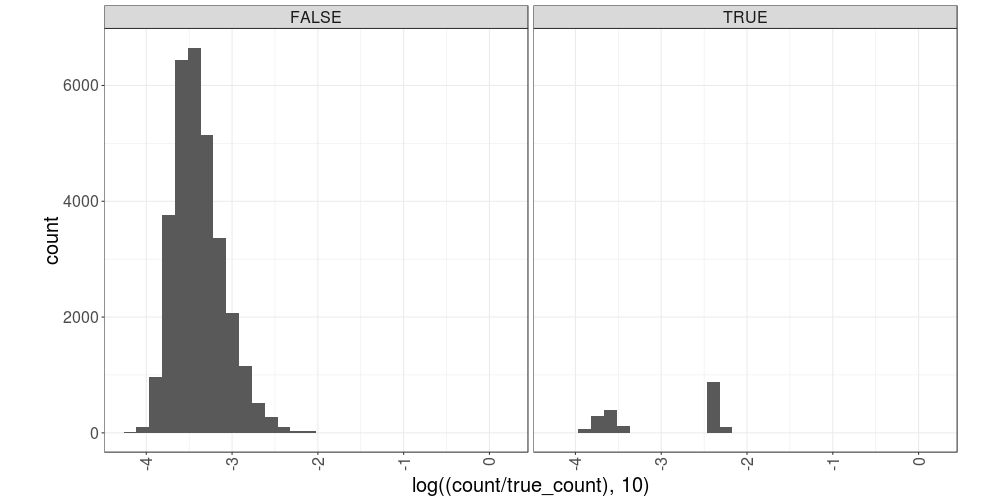

In [92]:
%%R -h 500 -w 1000
library(Hmisc)
duplication_error_barcodes$cell_qual_bin = cut2(duplication_error_barcodes$cell_qual, g=10)

p <- ggplot(duplication_error_barcodes, aes(cell_qual_bin, log((count/true_count),10))) +
geom_boxplot() + my_theme + facet_wrap(~N) +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)

p <- ggplot(duplication_error_barcodes, aes(log((count/true_count),10))) +
geom_histogram() + my_theme + facet_wrap(~N) +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)

In [84]:
%%R
tmp_df <- duplication_error_barcodes[duplication_error_barcodes$cell_qual<36,]
print(dim(tmp_df))
tmp_df <- tmp_df[tmp_df$cell_qual>35,]
print(dim(tmp_df))
tmp_df <- tmp_df[log((tmp_df$count/tmp_df$true_count),10)>(-3),]
print(head(tmp_df))
print(dim(tmp_df))

[1] 32557    17
[1]  0 17
 [1] error_barcode      cell               count              unique_umi_count  
 [5] dup._rate          read_qual          umi_qual           cell_qual         
 [9] specificity        alignment_rate     full_error         whitelist         
[13] N                  specificity_binary true_count         difference        
[17] cell_qual_bin     
<0 rows> (or 0-length row.names)
[1]  0 17


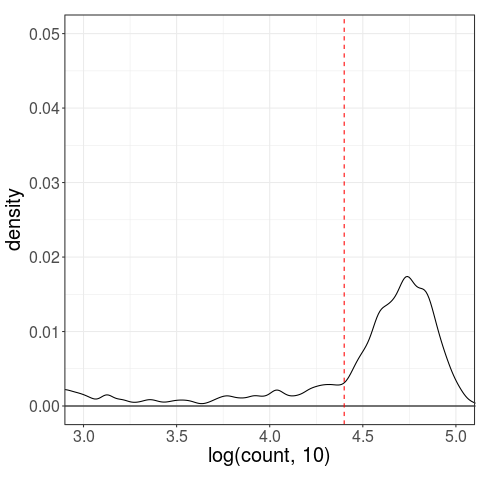

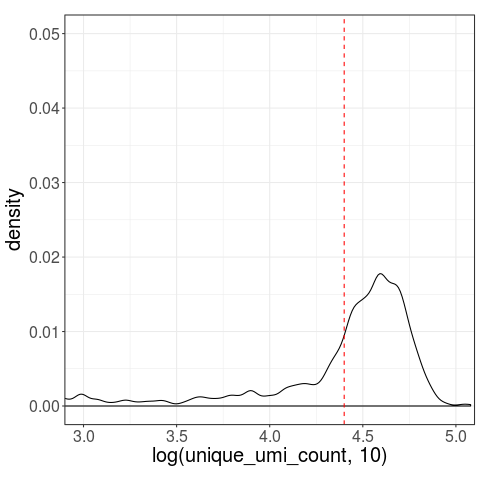

In [93]:
%%R
manual_threshold = 10^4.4
duplication_df$knee <- duplication_df$count > manual_threshold

p <- ggplot(duplication_df, aes(log(count,10))) + geom_density() + my_theme  +
geom_vline(xintercept=log(manual_threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(3,5), ylim=c(0,0.05))

print(p) 

p <- ggplot(duplication_df, aes(log(unique_umi_count,10))) + geom_density() + my_theme  +
geom_vline(xintercept=log(manual_threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(3,5), ylim=c(0,0.05))

print(p) 


                   cell  count unique_umi_count dup._rate   read_qual
578935 GTTAAGCTCAACTCTT 178148           119976 0.3265375 0.004482569
618369 GTGCTTCTCGGGAGTA 164945           111737 0.3225803 0.005155329
492044 ACGAGGAGTAGGGACT 156426           107095 0.3153632 0.004694452
550605 GACTAACAGGCGCTCT 126206            87456 0.3070377 0.004521751
521024 GGCAATTAGGAATCGC 124574            86563 0.3051279 0.004609734
240215 CGGGTCATCGGCGCTA 123082            86335 0.2985571 0.005125443
           umi_qual    cell_qual specificity alignment_rate full_error
578935 0.0004395898 0.0006720524   0.9597919      0.9669151           
618369 0.0004839715 0.0007760426   0.9592713      0.9663282           
492044 0.0004932131 0.0007322853   0.9585427      0.9651848           
550605 0.0005219179 0.0006644521   0.9597404      0.9669112           
521024 0.0004923316 0.0007077251   0.6578981      0.9598391           
240215 0.0005629201 0.0008339368   0.9575405      0.9642352           
       error_

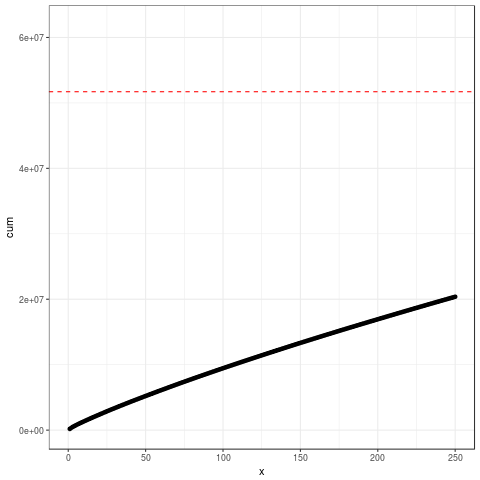

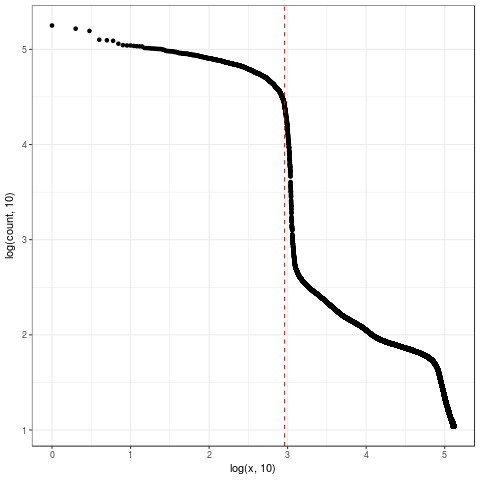

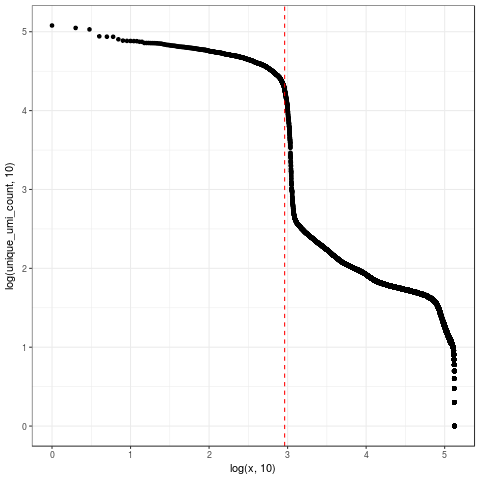

In [87]:
%%R
tmp_df <- duplication_df[order(-duplication_df$count),]
tmp_df$x <- seq(1, length(tmp_df[,1]))
tmp_df$cum <- cumsum(tmp_df$count)

tmp_df2 <- duplication_df[order(-duplication_df$unique_umi_count),]
tmp_df2$x <- seq(1, length(tmp_df2[,1]))
tmp_df2$cum <- cumsum(tmp_df2$unique_umi_count)

print(head(tmp_df))

print(tmp_df[tmp_df$x==length(tmp_df$count>manual_threshold),])

threshold_y_cum = sum(tmp_df[tmp_df$knee==TRUE, "count"])
print(threshold_y_cum)
threshold_x_cum = sum(tmp_df$knee==TRUE)

p <- ggplot(tmp_df, aes(x, cum)) + geom_point() + theme_bw() + xlim(0, 250) +
geom_hline(yintercept=threshold_y_cum, linetype=2, colour="red") +
geom_vline(xintercept=threshold_x_cum, linetype=2, colour="red")
print(p)


p <- ggplot(tmp_df, aes(log(x,10), log(count,10))) + geom_point() + theme_bw() + theme_bw()  +
geom_vline(xintercept=log(threshold_x_cum,10), linetype=2, colour="red")
print(p)

p <- ggplot(tmp_df2, aes(log(x,10), log(unique_umi_count,10))) + geom_point() + theme_bw()  +
geom_vline(xintercept=log(threshold_x_cum,10), linetype=2, colour="red")
print(p)
